# Import libraries

In [2]:
import os
from re import search
from dfply import *
import igraph
import fa2

# Load settings

In [3]:
if search("ricard", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/ricard/gastrulation10x/utils.py').read())
elif search("BI2404M", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/argelagr/gastrulation10x/utils.py').read())
else:
    exit("Computer not recognised")

## Define I/O

In [4]:
io["outdir"] = io["basedir"] + "/results/trajectories/blood_scanpy"

## Define options 

scanpy options

In [5]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.figdir = io["outdir"]
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

In [6]:
opts["stages"] = [
	"E6.5",
	"E6.75",
	"E7.0",
	"E7.25",
	"E7.5",
	"E7.75",
	"E8.0",
	"E8.25",
	"E8.5",
	"mixed_gastrulation"
]

opts["celltypes"] = [
   # "Epiblast",
   # "Primitive_Streak",
   # "Caudal_epiblast",
   # "PGC",
   # "Anterior_Primitive_Streak",
   # "Notochord",
   # "Def._endoderm",
   # "Gut",
   # "Nascent_mesoderm",
   "Mixed_mesoderm",
   # "Intermediate_mesoderm",
   # "Caudal_Mesoderm",
   # "Paraxial_mesoderm",
   # "Somitic_mesoderm",
   # "Pharyngeal_mesoderm",
   # "Cardiomyocytes",
   # "Allantois",
   # "ExE_mesoderm",
   # "Mesenchyme",
   "Haematoendothelial_progenitors",
   "Endothelium",
   "Blood_progenitors_1",
   "Blood_progenitors_2",
   "Erythroid1",
   "Erythroid2",
   "Erythroid3"
   # "NMP",
   # "Rostral_neurectoderm",
   # "Caudal_neurectoderm",
   # "Neural_crest",
   # "Forebrain_Midbrain_Hindbrain",
   # "Spinal_cord",
   # "Surface_ectoderm",
   # "Visceral_endoderm",
   # "ExE_endoderm",
   # "ExE_ectoderm",
   # "Parietal_endoderm"
]

## Load cell metadata

In [7]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X["stripped"]==False, X["doublet"]==False) >>
    mask(X["stage"].isin(opts["stages"]), X["celltype"].isin(opts["celltypes"]))
)
metadata.shape

(15875, 12)

In [8]:
metadata.head()

,cell,barcode,sample,stage,sequencing.batch,doublet,stripped,celltype,umapX,umapY,nFeature_RNA,nCount_RNA
11,cell_100006,GACTGTGAGGACAG,29,E8.5,3,False,False,Erythroid3,8.538226,7.548652,2819,18907
20,cell_100015,GACTTTACTGGATC,29,E8.5,3,False,False,Erythroid3,9.761636,5.911193,3115,21040
26,cell_100020,GAGAAATGCCACAA,29,E8.5,3,False,False,Erythroid3,9.623819,6.548942,3002,20182
38,cell_100032,GAGATAGATACTCT,29,E8.5,3,False,False,Haematoendothelial_progenitors,-1.219938,11.407623,2334,7092
45,cell_100040,GAGATGCTCTGTAG,29,E8.5,3,False,False,Erythroid2,8.000846,9.198536,3795,26487


# Load anndata object

In [9]:
adata = load_adata(
    adata_file = io["anndata"], 
    metadata_file = io["metadata"],
    cells = metadata.cell.values, 
    normalise = True, 
    filter_lowly_expressed_genes = True
)
adata

/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 15875 × 15951
    obs: 'cell', 'barcode', 'sample', 'stage', 'sequencing.batch', 'doublet', 'stripped', 'celltype', 'umapX', 'umapY', 'nFeature_RNA', 'nCount_RNA'
    var: 'n_counts'
    uns: 'celltype_colors', 'clusterMergedHierarchy_colors', 'clusterMergedHierarchy_sizes', 'clusterSubUnique_colors', 'clusterSubUnique_sizes', 'diffmap_evals', 'neighbors', 'paga', 'stage_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [10]:
adata.obs["celltype"].value_counts()

Erythroid1                        2929
Haematoendothelial_progenitors    2733
Erythroid3                        2697
Blood_progenitors_2               2587
Mixed_mesoderm                    1994
Erythroid2                        1106
Endothelium                       1084
Blood_progenitors_1                745
Name: celltype, dtype: int64

/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'barcode' as categorical
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

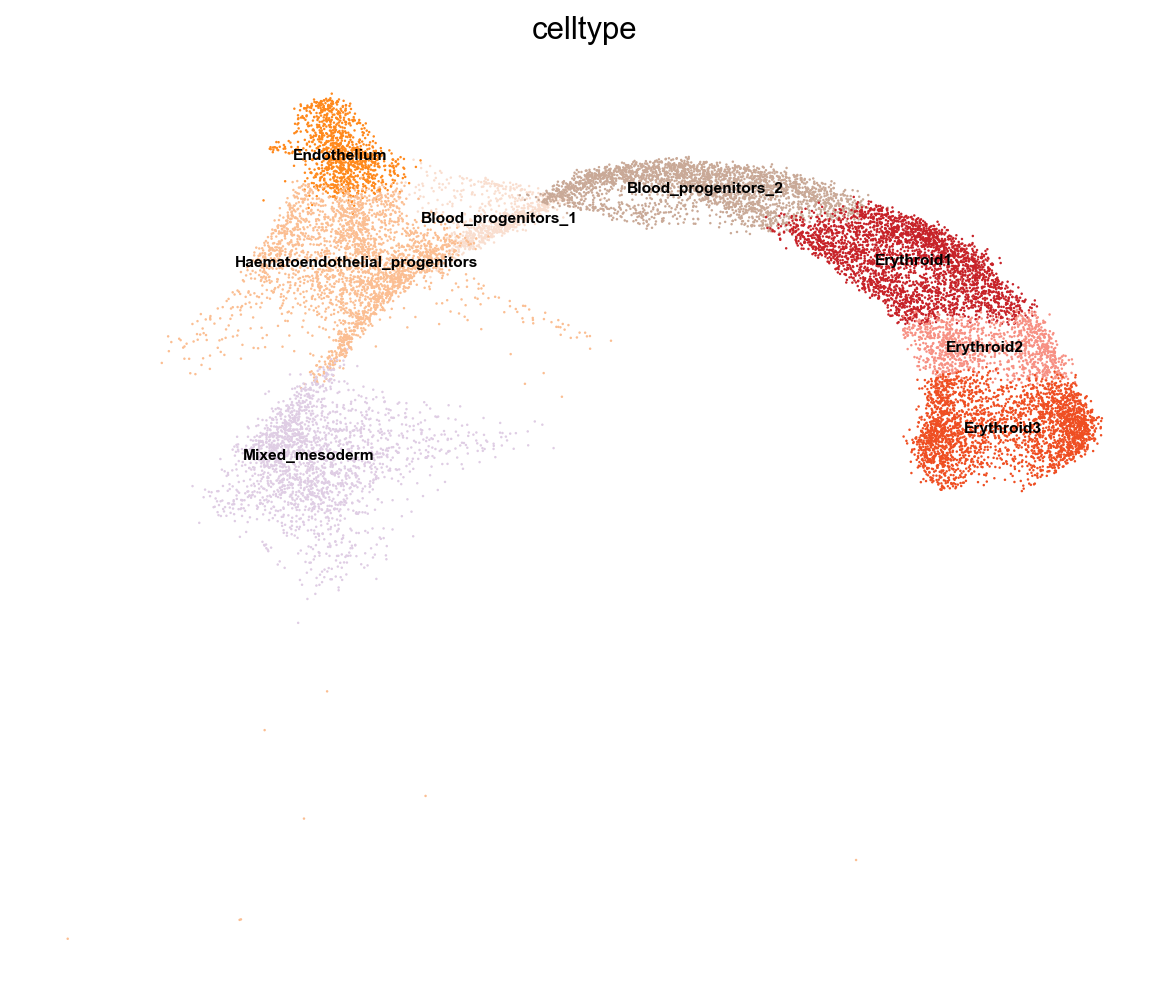

In [11]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=5, legend_loc='on data', legend_fontsize=7)

## Feature selection

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [13]:
adata.var["highly_variable"].sum()

1000

## Dimensionality reduction

### PCA

In [14]:
sc.tl.pca(adata, n_comps=15)

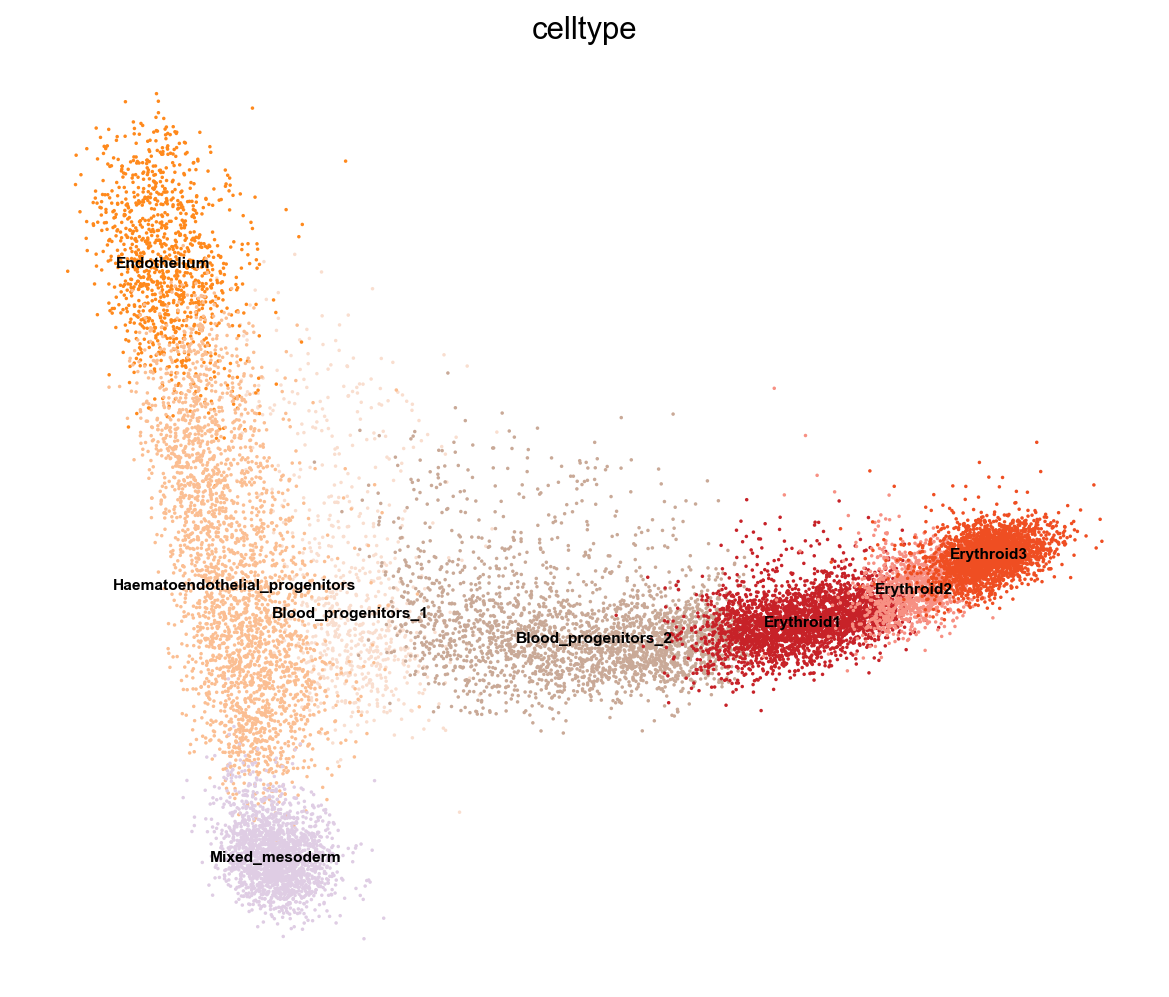

In [15]:
sc.pl.scatter(adata, color='celltype', basis="pca", size=10, legend_loc='on data', legend_fontsize=7, 
              save="blood_pca_celltype.pdf")

## Compute neighbors

In [16]:
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca')

### UMAP

In [17]:
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

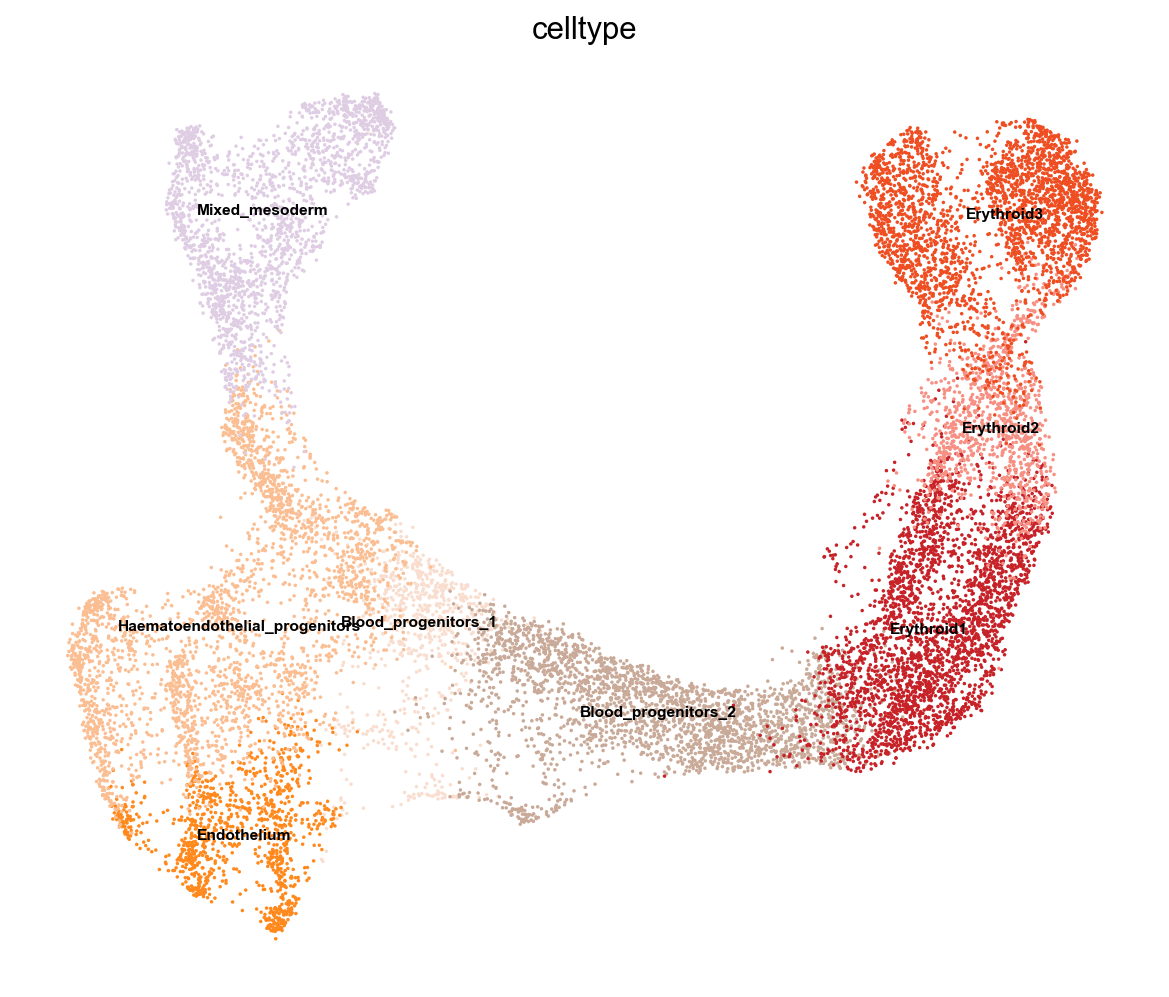

In [18]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=10, legend_loc='on data', legend_fontsize=7,
              save = "blood_umap_celltype.pdf")

In [19]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_umap, X_tsne, X_diffmap)

### Force-directed layout

In [20]:
sc.tl.draw_graph(adata, layout='fa', init_pos=None)

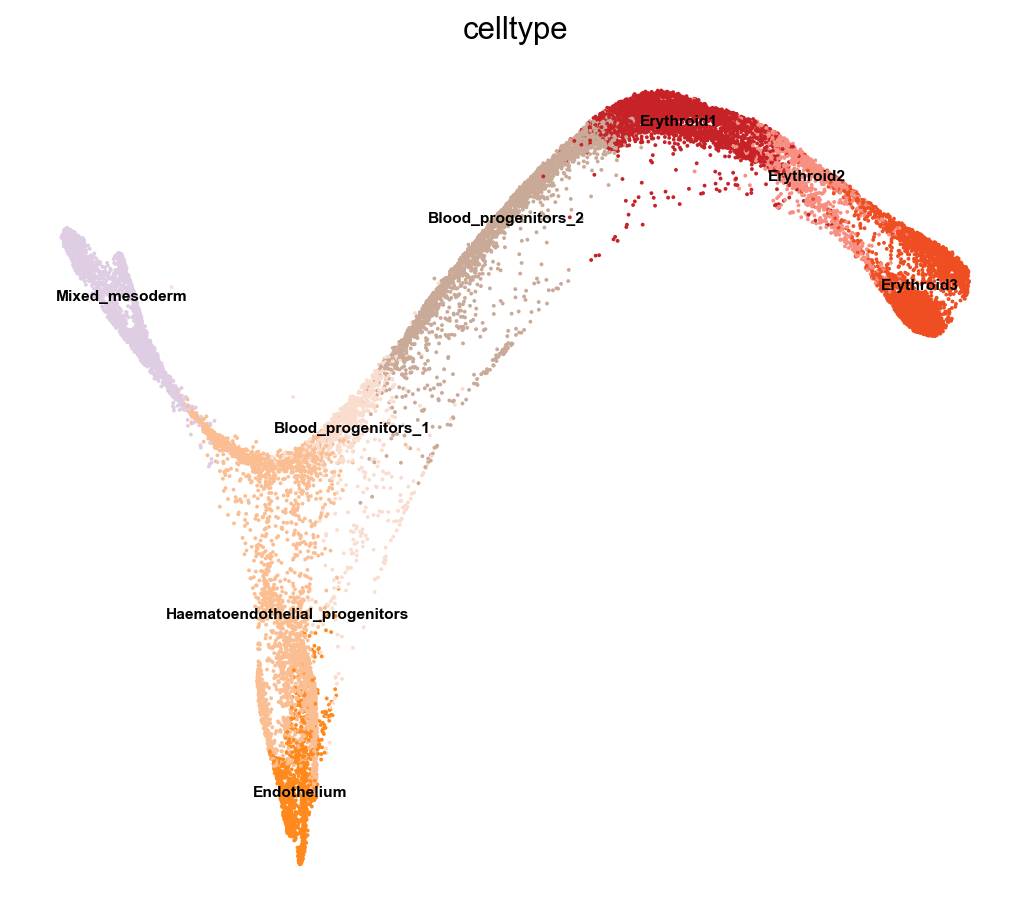

In [29]:
# sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')
sc.pl.draw_graph(adata, color='celltype', size=12, legend_loc='on data', legend_fontsize=7,
              save = "blood_fa2_celltype.pdf")

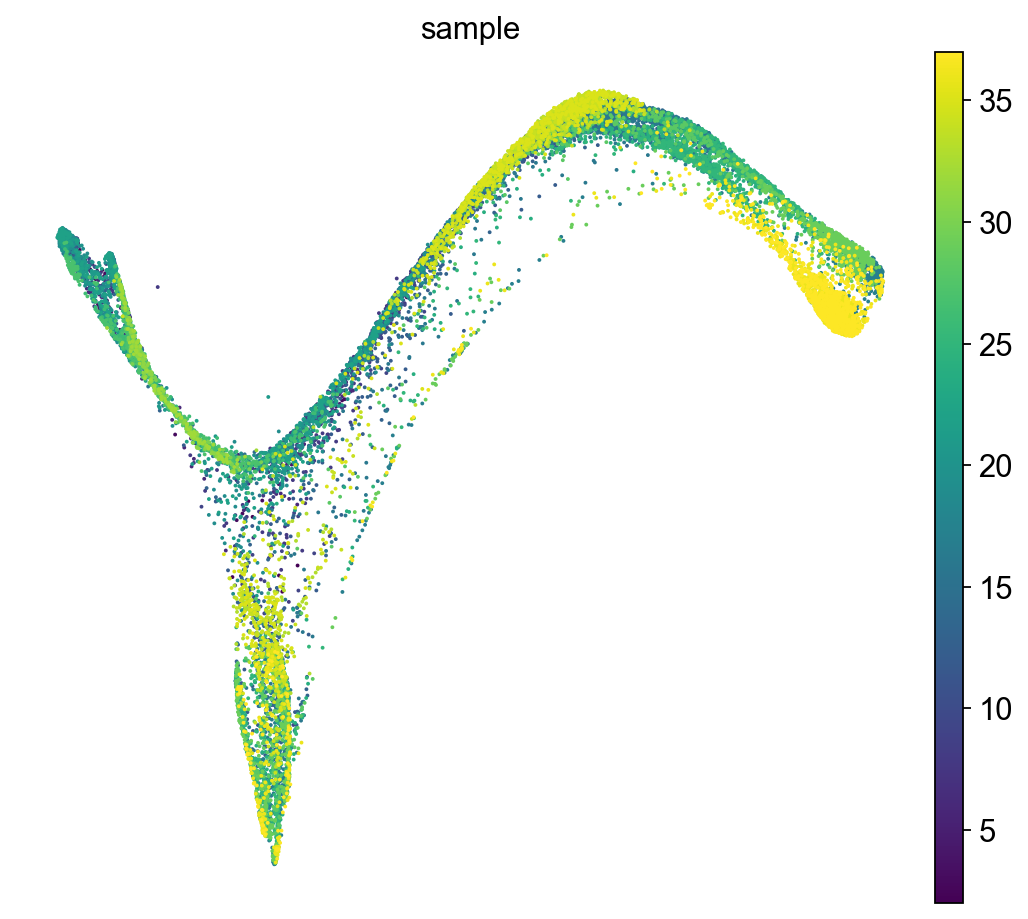

In [31]:
sc.pl.draw_graph(adata, color='sample', size=12, legend_loc='on data', legend_fontsize=7,
              save = "blood_fa2_sample.pdf")

## Graph abstraction


In [22]:
sc.tl.paga(adata, groups='celltype')

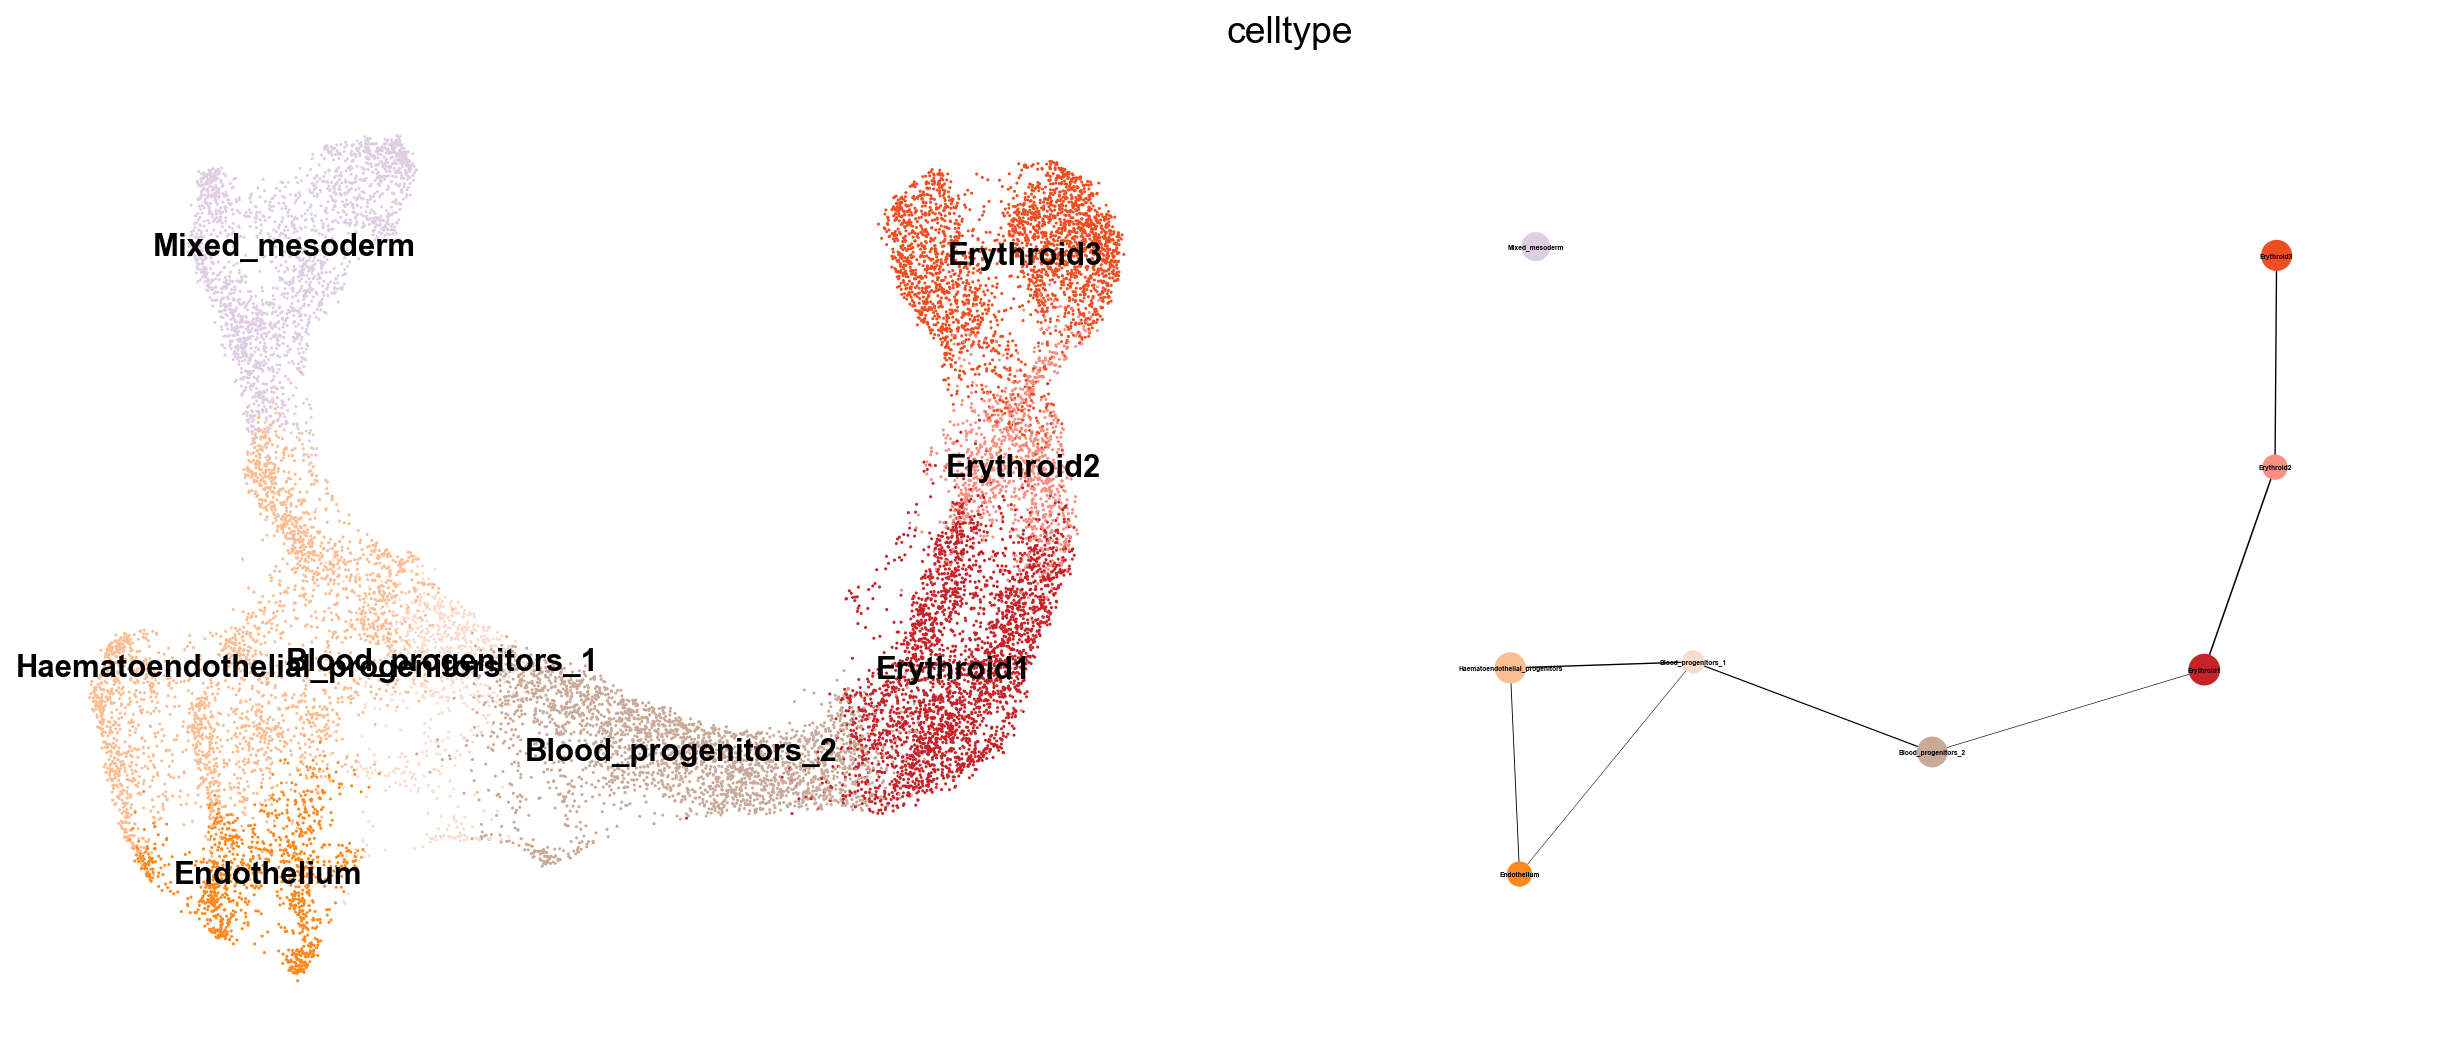

In [23]:
sc.pl.paga_compare(adata, basis='umap',legend_loc='on data',
                   fontsize=3, threshold=0.23, color='celltype', edge_width_scale=0.1)

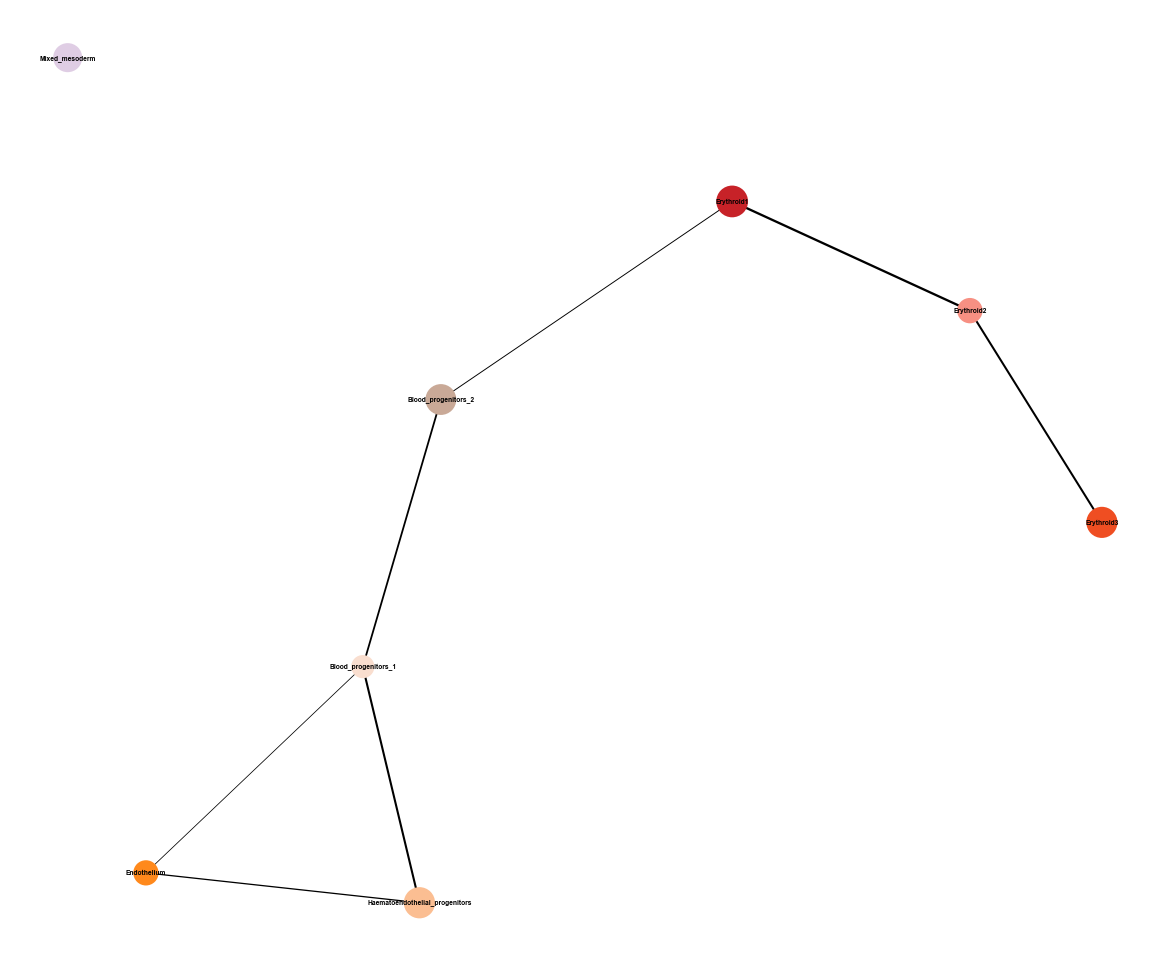

In [24]:
sc.pl.paga(adata, threshold=0.3, fontsize=3, edge_width_scale=0.15, node_size_power=0.5, color='celltype')

recomputing the graph using PAGA initialisation

In [25]:
sc.tl.draw_graph(adata, layout='fa', init_pos="paga")

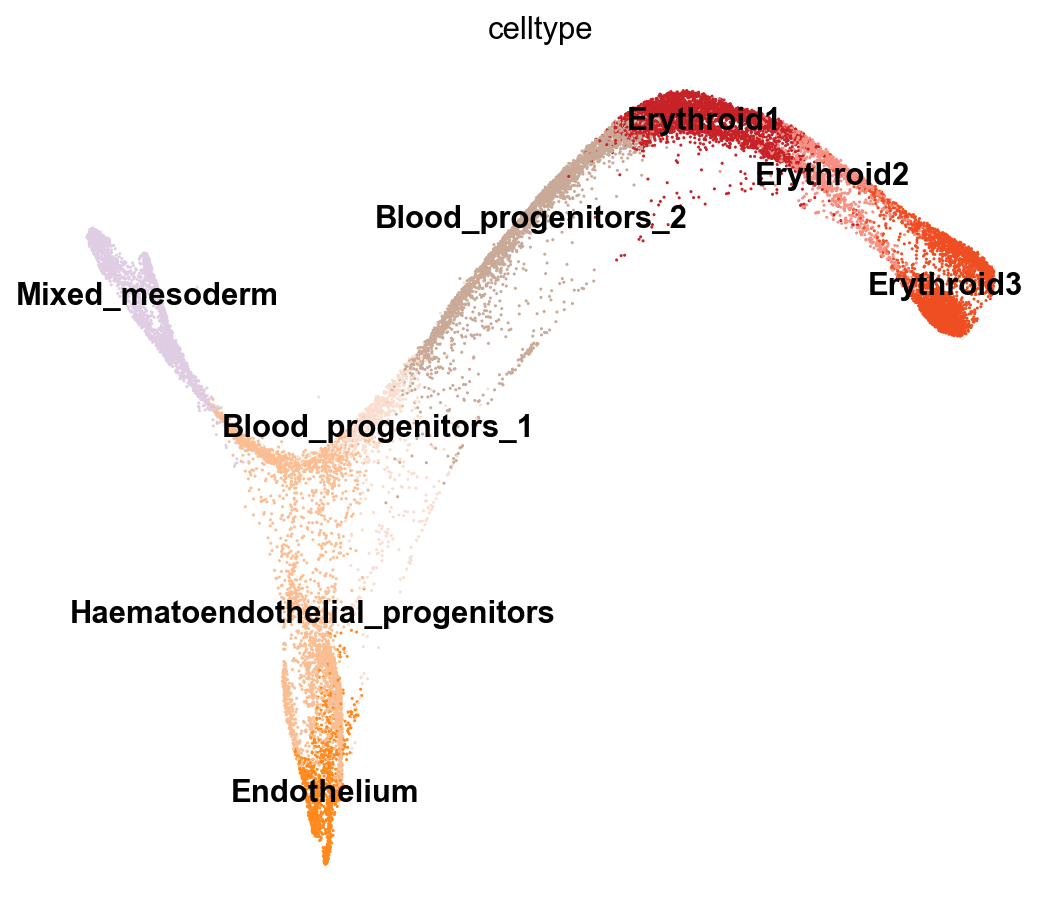

In [26]:
sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')

## Save

In [37]:
trajectory = pd.DataFrame(adata.obsm["X_draw_graph_fa"], index=adata.obs_names, columns=["FA1","FA2"])
trajectory.to_csv(io["outdir"] + "/blood_trajectory.txt.gz", sep='\t')

In [27]:
adata.write(io["outdir"] + "/blood_anndata.h5ad")
metadata.to_csv(io["outdir"] + "/blood_sample_metadata.txt.gz", sep='\t')
metadata.to_csv(io["outdir"] + "/blood_sample_metadata.txt.gz", sep='\t')

ValueError: Unable to create dataset (name already exists)

Above error raised while writing key 'cell' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'obs' of <class 'h5py._hl.files.File'> from /.